In [1]:
import numpy as np
import pandas as pd
import datetime
from cuzco import time_series
from cuzco import anomaly_explanation
from cuzco import get_views
from cuzco import keywords_names_extraction
import matplotlib.pyplot as plt
import time
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 0.7})

from imp import reload
reload(time_series);

## Anomaly detection

In [202]:
views_sun = get_views.get_views_simple(newspaper='sun', granularity='minute', 
                                       start_date='2017-05-24',
                                       end_date='2017-06-06')

Creating... data/views_sun_by_minute_2017-05-24_2017-06-06.csv
File already exists!


In [205]:
anomaly_data_frame = time_series.predict_last_period(input_data_frame=views_sun,
                                                      input_granularity='minute',
                                                      detection_granularity='day',tolerance=6.7,
                                                     detection_period=14,verbose=True, clustered = True)

Using tolerance 6.70
**************
Summary Report 
**************
Percentage of anomalies in the period: 0.034%
Time for detection: 0.242 seconds


In [204]:
len(anomaly_data_frame)

677

In [111]:
a1 = anomaly_data_frame['date_time'].get_values()

In [112]:
twitter_algorithm = pd.read_csv('validation.csv')

In [113]:
a2= twitter_algorithm['timestamp'].get_values()

In [114]:
a2 = np.array([date.replace('/','-') for date in a2])
a1 = np.array([date[:-3] for date in a1])

In [115]:
a1 = np.array([date[8:10]+'-'+date[5:7]+'-'+date[:4] + date[10:] for date in a1])

In [122]:
len(a1)

677

In [123]:
len(a2)

673

In [124]:
len(np.intersect1d(a1,a2))

657

In [194]:
yahoo = pd.DataFrame()
for i in range(1,68):
    yahoo = yahoo.append(pd.read_csv('data/real_'+str(i)+'.csv'))
    

In [196]:
len(yahoo)

94866

In [197]:
yahoo.rename(columns={'value':'views'},inplace=True)

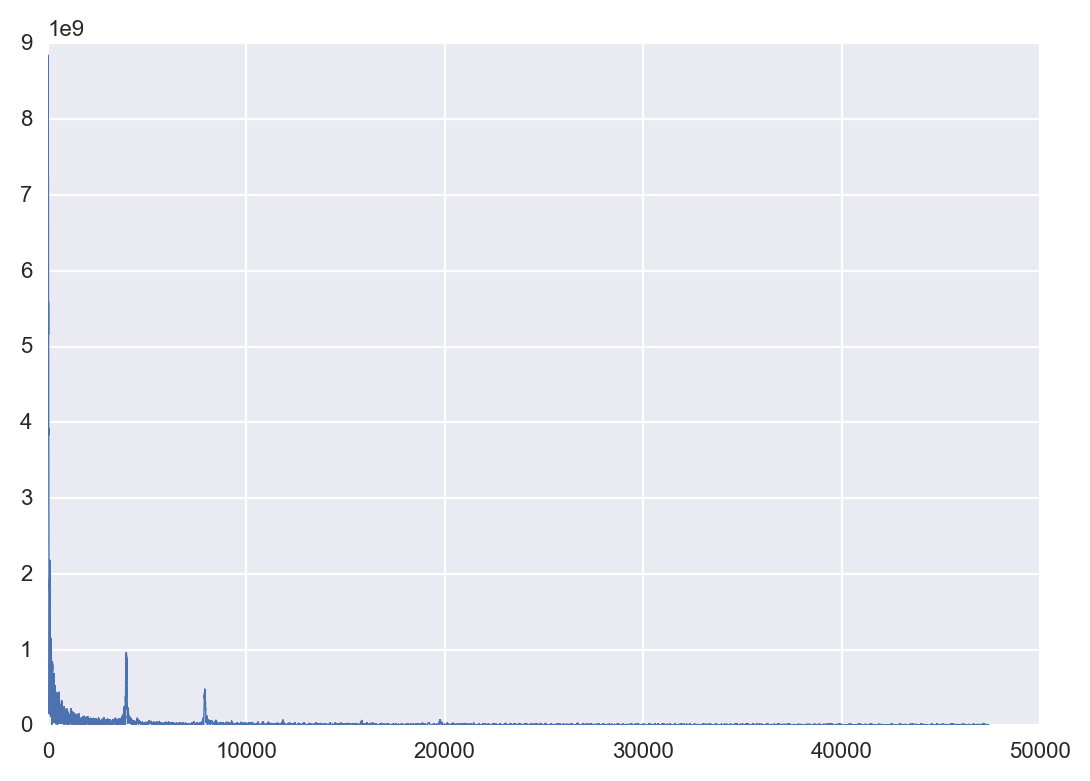

In [198]:
plt.plot(np.abs(np.fft.fft(yahoo['views']))[1:int(len(yahoo['views'])/2)]);

In [151]:
np.argsort(np.abs(np.fft.fft(yahoo['views']))[1:int(len(yahoo['views'])/2)])[::-1]

array([  0,  58,   1,   2, 118,   3, 117,   6,  57,  56,   7,  13,  59,
         4,  60,  33, 115,  22,  15, 470, 150, 211, 649,  14, 553, 537,
       265,  78, 507, 473,   9,  55, 301,  63,  84, 380,  96,  69,  67,
       318, 585, 198,  17,  70, 525, 422,  54, 270,  29, 674, 168, 509,
        19, 488, 612, 689,  27,  61, 648, 697,  10, 144,  75, 477, 458,
       605,  72,  16, 156, 299, 243,  98,   8, 245,  79, 176, 225, 676,
       432, 660, 524, 148, 139, 526, 410, 552, 431, 621,  12, 544,  38,
       348, 242, 515, 574, 656,  62,  49, 206, 213, 424, 357, 539, 496,
       438, 467, 376, 472, 113, 499,  74, 140, 698, 334,  25, 285, 254,
       116,  41,   5,  26,  91, 681, 586, 320, 297, 204, 568,  71, 197,
       419, 529,  68, 387, 248, 359, 287, 269, 251,  53, 366, 332,  45,
       641, 608, 146, 639, 250, 498, 522, 535, 241, 170, 288, 365, 145,
        95, 677, 337, 203,  37, 114, 131, 682, 479,  36, 284,  97,  82,
       394, 142, 101, 268, 703, 483,  28, 108, 356, 110, 624, 10

In [171]:
1440/58

24.82758620689655

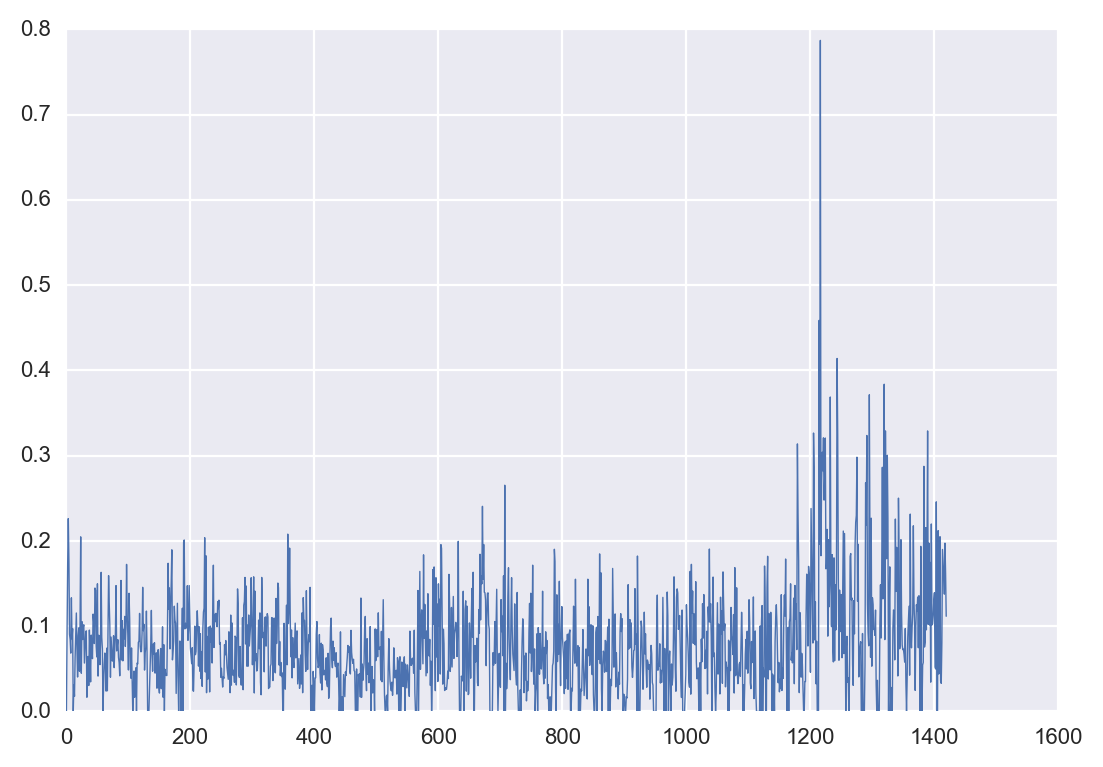

In [142]:
plt.plot(yahoo['views']);

In [172]:
time_series.global_anomaly_detection(yahoo,window=118,periodicity=118,tolerance=10)

,timestamp,views,is_anomaly,deviations
1214,1215,0.458686,1,0.383962
1216,1217,0.787127,1,0.694541
1232,1233,0.368842,0,0.316657
1243,1244,0.414026,0,0.360393
1319,1320,0.383823,0,0.326453


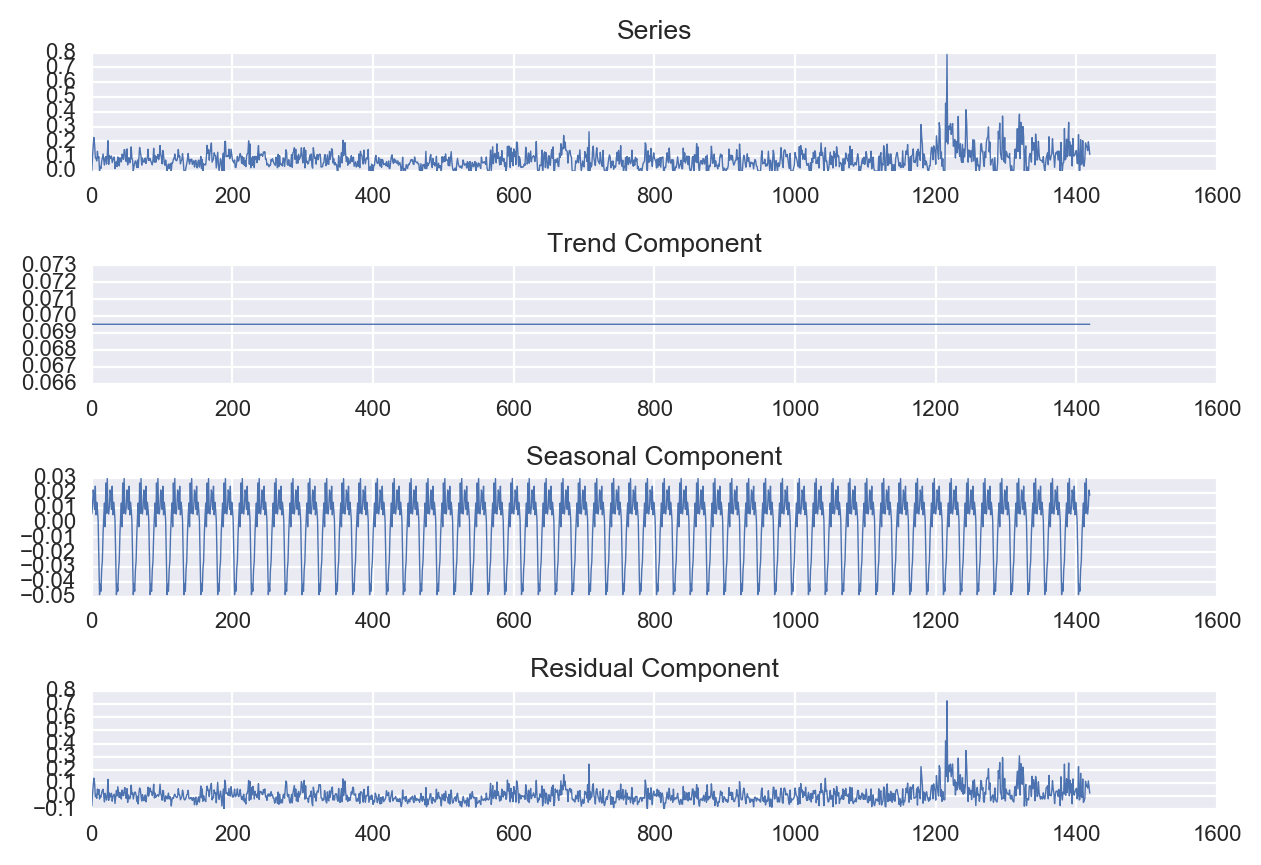

In [173]:
a = time_series.time_series_decomposition(input_series=yahoo['views'],plot=True,periodicity=24)

In [186]:
tols = np.arange(5,15,1)
FP = []
TP = []
for tol in tols:
    anomaly = time_series.global_anomaly_detection(yahoo,window=118,periodicity=118,tolerance=tol)
    FP += [len(anomaly[anomaly['is_anomaly']==0])/len(yahoo[yahoo['is_anomaly']==0])]
    TP += [len(anomaly[anomaly['is_anomaly']==1])/len(yahoo[yahoo['is_anomaly']==1])]

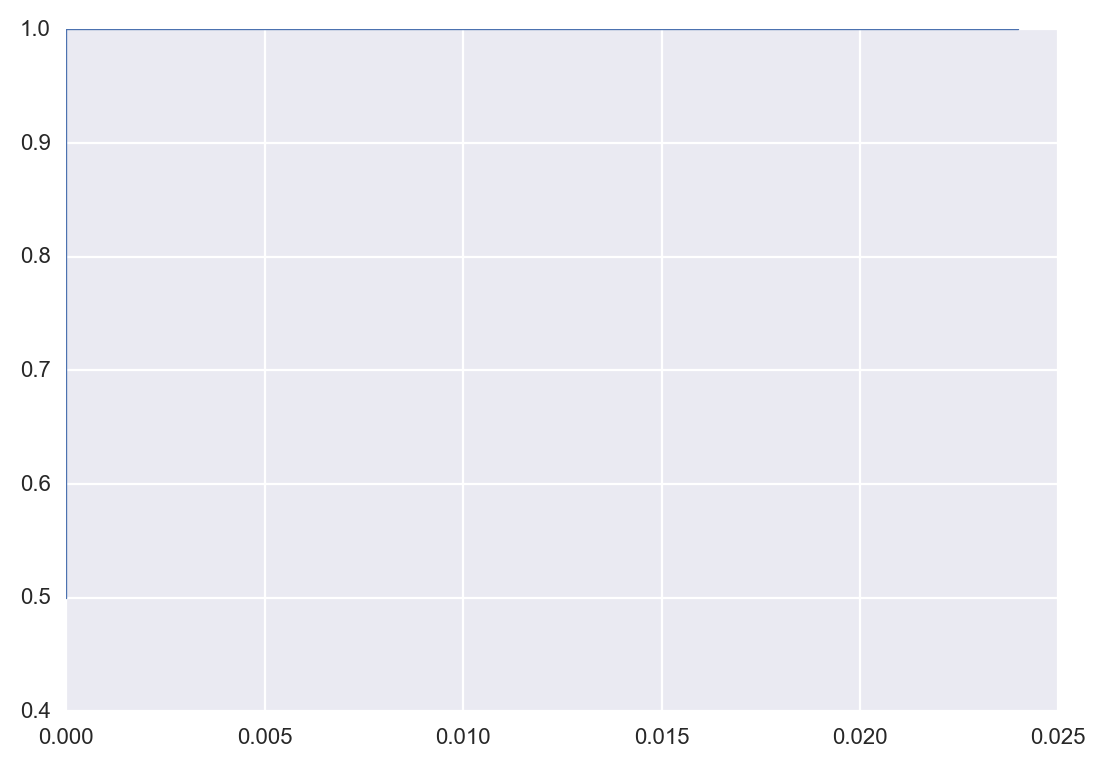

In [189]:
plt.plot(FP,TP)

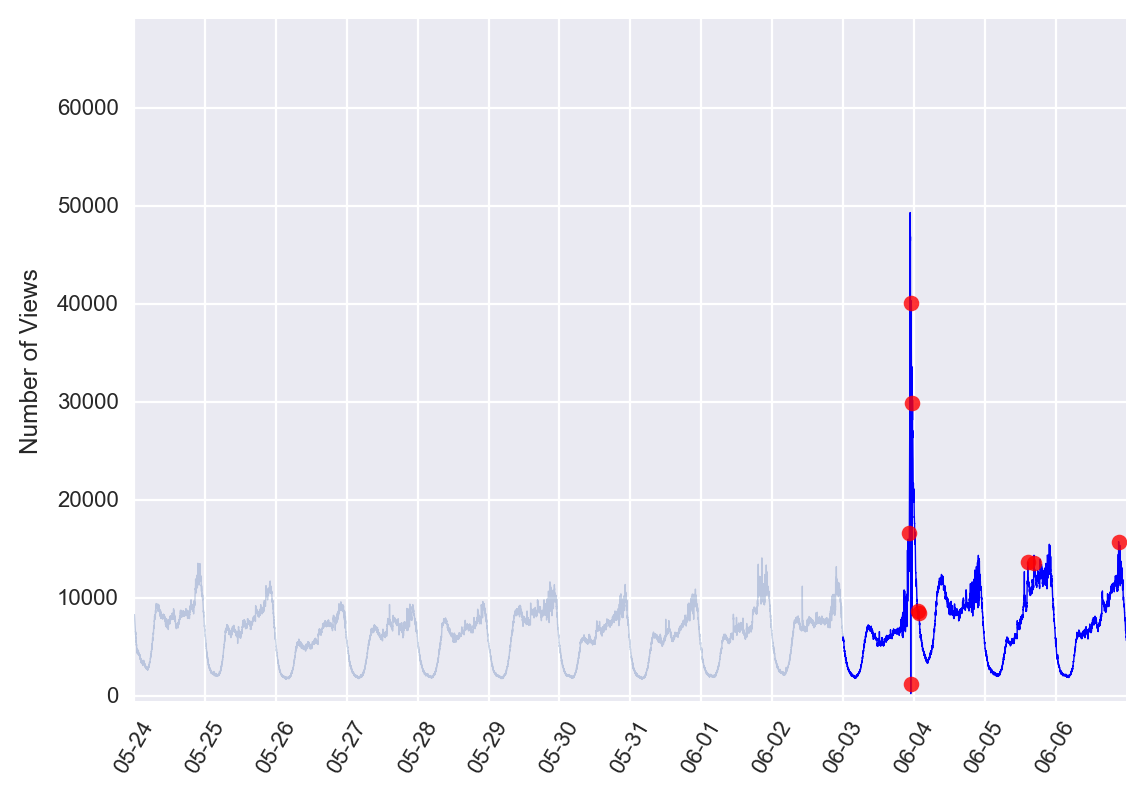

In [13]:
time_series.plot_detected_anomalies(input_data_frame=views_sun, anomaly_data_frame=anomaly_data_frame,
                                    input_granularity='minute', detection_granularity='day', detection_period=4)

## Traffic Report

The following part of the code downloads the views per section and attemps to explain the anomaly section-wise

In [21]:
# A sample list of categories of interest
categories = ['news', 'living', 'money', 'motors', 'sport', 'tv & showbiz', 'tech', 'travel', 'all']
categories = [cat.lower() for cat in categories]

input_data_frame_by_section = get_views.get_views_section(newspaper='sun', granularity='minute',
                                                          start_date='2017-05-24',end_date='2017-06-06')

File already exists!


In [22]:
t0 = time_series.extract_date_time(views_sun[['date','hour','minute']].iloc[0])

views_sun = time_series.insert_date_time_columns(views_sun, t0=t0)
views_sun_by_section = time_series.insert_date_time_columns(input_data_frame_by_section, t0=t0)
anomaly_data_frame = time_series.insert_date_time_columns(anomaly_data_frame, t0=t0)

In [23]:
index = np.unique(views_sun.time_until_start)
total_time_array = np.arange(min(index), max(index)+1)

list_of_data_frames = [input_data_frame_by_section[views_sun_by_section['section']==cat] for cat in categories]
list_of_data_frames = [anomaly_explanation.fill_the_time_series_gaps(input_data_frame=df, total_time_array=total_time_array)
                      for df in list_of_data_frames]

list_of_data_frames = [df for df in list_of_data_frames]

In [24]:
anomaly_explanation.traffic_report(list_of_data_frames=list_of_data_frames, 
                                   overall_data_frame=views_sun,
                                   anomaly_description=anomaly_data_frame,
                                   list_of_categories=categories,
                                   file_name='cuzco_report_complete.txt',complete=True)

Saving traffic report log...Done!


In [25]:
def extract_end_date_time(d0):
    """ 
    Concatenates date, hour and minute into a timestamp and adds the width (assumed to be in minutes).
    d0 = dataframe of anomalies containing columns for date, hour, minute and width.
    """
    return datetime.datetime.strptime(d0['date']+' '+str(d0['hour'])+' '+str(d0['minute']),'%Y-%m-%d %H %M') + datetime.timedelta(minutes = d0['width'])


def insert_end_date_time_columns(input_data_frame):
    """
    Inserts columns with date times. 
    Assumes that time is in minutes.
    
    :param input_data_frame: pandas dataframe with day, hour and minute columns.
    :return: input_data_frame with new column containing datetime rounded to minutes.
    
    """

    input_data_frame['end_date_time'] = 0
    input_data_frame['end_date_time'] = input_data_frame[['date', 'hour', 'minute', 'width']].apply(extract_end_date_time, axis=1) 
    
    return input_data_frame

In [26]:
t0 = time_series.extract_date_time(views_sun[['date','hour','minute']].iloc[0])

anomaly_data_frame = time_series.insert_date_time_columns(anomaly_data_frame, t0=t0)
anomaly_data_frame = insert_end_date_time_columns(anomaly_data_frame)

In [27]:
from imp import reload
reload(keywords_names_extraction);

In [28]:
words = keywords_names_extraction.article_keywords(paper = 'times', first='2017-06-04 08:23:00', last='2017-06-04 08:25:00')

Requesting query... ok.
Job ID: job_DJ9TGjl15SbDx3mGoM9CnDuevl_n
Query running...
Query done.
Processed: 789.7 MB
Standard price: $0.00 USD

Retrieving results...
Got 100 rows.

Total time taken 2.77 s.
Finished at 2017-09-04 10:11:48.


In [29]:
dic = words[:1]['article_keywords'][0]

In [30]:
dic['keywords_2lines'][:2]

['nearby borough market', 'london bridge attack']